# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
import warnings
import shap

warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [4]:
TRAIN_PATH = "./db/train_data.csv"
VAL_PATH   = "./db/val_data.csv"
TEST_PATH  = "./db/test_data.csv"
TARGET_COL = "label"
DROP_COLS  = ["patient_id", "date"]

# Datasets

In [5]:
train = pd.read_csv(TRAIN_PATH)
val   = pd.read_csv(VAL_PATH)
test  = pd.read_csv(TEST_PATH)

In [6]:
X_train = train.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in train.columns])
y_train = train[TARGET_COL].copy()
X_val   = val.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in val.columns])
y_val   = val[TARGET_COL].copy()
X_test  = test.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in test.columns])
y_test  = test[TARGET_COL].copy()

# Modelagem

In [7]:
def resample_train(X, y, target_ratio=1.0, random_state=42):
    target_ratio = 2
    # ensure pandas DataFrame / Series
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    if not isinstance(y, pd.Series):
        y = pd.Series(y, name=TARGET)

    pos_idx = y[y == 1].index.to_numpy()
    neg_idx = y[y == 0].index.to_numpy()

    n_pos = len(pos_idx)
    n_neg = len(neg_idx)

    if n_pos == 0 or n_neg == 0:
        # nothing to do
        return X.reset_index(drop=True), y.reset_index(drop=True)

    # desired number of negatives (per positive * n_pos)
    n_neg_target = int(n_pos * float(target_ratio))

    # If want balanced 1:1, target_ratio = 1.0 => n_neg_target = n_pos
    # Strategy: first undersample negatives down to n_neg_target (if n_neg > n_neg_target)
    # then oversample positives up to n_neg_target (if n_pos < n_neg_target)
    rng = np.random.RandomState(random_state)


    neg_keep = rng.choice(neg_idx, size=n_neg_target, replace=False)


    extra_needed = n_neg_target - n_pos
    pos_extra = rng.choice(pos_idx, size=extra_needed, replace=True)
    pos_keep = np.concatenate([pos_idx, pos_extra])

#     pos_keep = pos_idx

    keep_idx = np.concatenate([neg_keep, pos_keep])
    rng.shuffle(keep_idx)

    X_res = X.loc[keep_idx].reset_index(drop=True)
    y_res = y.loc[keep_idx].reset_index(drop=True)

    return X_res, y_res

def evaluate(model, X, y, set_name="set"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, digits=4)
    cm = confusion_matrix(y, y_pred)

    print(f"\n---------------------------------- Avaliação no {set_name} ---------------------------------\n")
    print("Accuracy:", acc)
    print("\nClassification report:\n", report)
    print("Confusion matrix:\n", cm)

    unique_classes = np.unique(y)
    if len(unique_classes) == 2 and y_proba is not None:
        auc = roc_auc_score(y, y_proba)
        print("\nROC AUC:", auc)
        fpr, tpr, thr = roc_curve(y, y_proba)
        plt.figure(figsize=(12, 4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC curve - {set_name}")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return {"accuracy": acc, "report_str": report, "confusion_matrix": cm}

In [8]:
# Pipeline

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0

pipeline = Pipeline([
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE, scale_pos_weight=scale_pos_weight, n_jobs=-1))
])

In [9]:
# Definição de espaço de buscam do Random Search
param_distributions = {
    "xgb__n_estimators": randint(50, 1000),
    "xgb__max_depth": randint(3, 12),
    "xgb__learning_rate": uniform(loc=0.001, scale=0.5),
    "xgb__subsample": uniform(loc=0.5, scale=0.5),
    "xgb__colsample_bytree": uniform(loc=0.3, scale=0.7),
    "xgb__gamma": uniform(loc=0.0, scale=5.0),
    "xgb__min_child_weight": randint(1, 10),
    "xgb__reg_alpha": uniform(loc=0.0, scale=1.0),
    "xgb__reg_lambda": uniform(loc=0.0, scale=10.0)
}

In [10]:
cv = TimeSeriesSplit(n_splits=5)
n_iter = 10
X_train_fit = X_train
y_train_fit = y_train

In [11]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring="accuracy",
    cv=cv,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True
)

# Fit com Dados Reais

In [12]:
random_search.fit(X_train_fit, y_train_fit)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=N...
                                        'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a233dc70dd0>,
                                        'xgb__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a233dc70d70>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a233dc70470>},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=2)

In [13]:
best_model = random_search.best_estimator_

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("\nMelhor score CV (scoring chosen):", random_search.best_score_)

Melhores parâmetros encontrados:
{'xgb__colsample_bytree': np.float64(0.7322370567394015), 'xgb__gamma': np.float64(3.0582658024414044), 'xgb__learning_rate': np.float64(0.004533152609858703), 'xgb__max_depth': 11, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 524, 'xgb__reg_alpha': np.float64(0.6118528947223795), 'xgb__reg_lambda': np.float64(1.3949386065204183), 'xgb__subsample': np.float64(0.6460723242676091)}

Melhor score CV (scoring chosen): 0.8832335329341318


# Avaliação com Dados Reais


---------------------------------- Avaliação no validation ---------------------------------

Accuracy: 0.9226190476190477

Classification report:
               precision    recall  f1-score   support

           0     0.9560    0.9620    0.9590       316
           1     0.3333    0.3000    0.3158        20

    accuracy                         0.9226       336
   macro avg     0.6447    0.6310    0.6374       336
weighted avg     0.9189    0.9226    0.9207       336

Confusion matrix:
 [[304  12]
 [ 14   6]]

ROC AUC: 0.8387658227848102


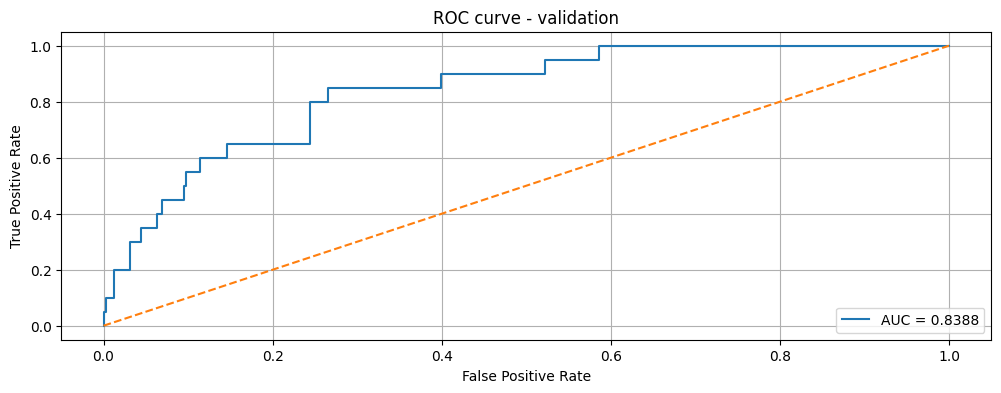


---------------------------------- Avaliação no test ---------------------------------

Accuracy: 0.789010989010989

Classification report:
               precision    recall  f1-score   support

           0     0.8516    0.9091    0.8794       385
           1     0.2045    0.1286    0.1579        70

    accuracy                         0.7890       455
   macro avg     0.5281    0.5188    0.5186       455
weighted avg     0.7520    0.7890    0.7684       455

Confusion matrix:
 [[350  35]
 [ 61   9]]

ROC AUC: 0.6961410018552876


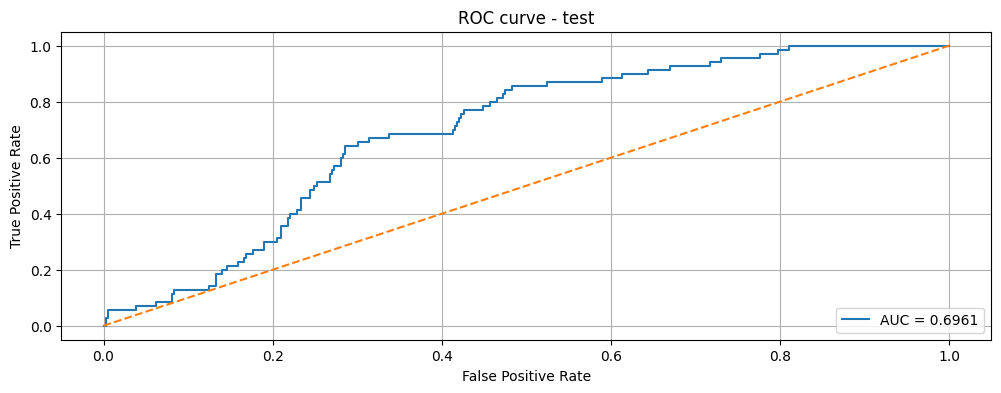

In [14]:
res_val = evaluate(best_model, X_val, y_val, set_name="validation")
res_test = evaluate(best_model, X_test, y_test, set_name="test")

# Fit com Resample

In [15]:
X_train_res, y_train_res = resample_train(X_train, y_train, target_ratio=1.0, random_state=RANDOM_STATE)

random_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=N...
                                        'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a233dc70dd0>,
                                        'xgb__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a233dc70d70>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a233dc70470>},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=2)

In [16]:
best_model_res = random_search.best_estimator_

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("\nMelhor score CV (scoring chosen):", random_search.best_score_)

Melhores parâmetros encontrados:
{'xgb__colsample_bytree': np.float64(0.5564532903055841), 'xgb__gamma': np.float64(2.28034992108518), 'xgb__learning_rate': np.float64(0.3935879806965068), 'xgb__max_depth': 5, 'xgb__min_child_weight': 7, 'xgb__n_estimators': 293, 'xgb__reg_alpha': np.float64(0.5924145688620425), 'xgb__reg_lambda': np.float64(0.46450412719997725), 'xgb__subsample': np.float64(0.8037724259507192)}

Melhor score CV (scoring chosen): 0.8186915887850468


# Avaliação com Resample


---------------------------------- Avaliação no validation ---------------------------------

Accuracy: 0.7976190476190477

Classification report:
               precision    recall  f1-score   support

           0     0.9806    0.8006    0.8815       316
           1     0.1923    0.7500    0.3061        20

    accuracy                         0.7976       336
   macro avg     0.5865    0.7753    0.5938       336
weighted avg     0.9337    0.7976    0.8473       336

Confusion matrix:
 [[253  63]
 [  5  15]]

ROC AUC: 0.830379746835443


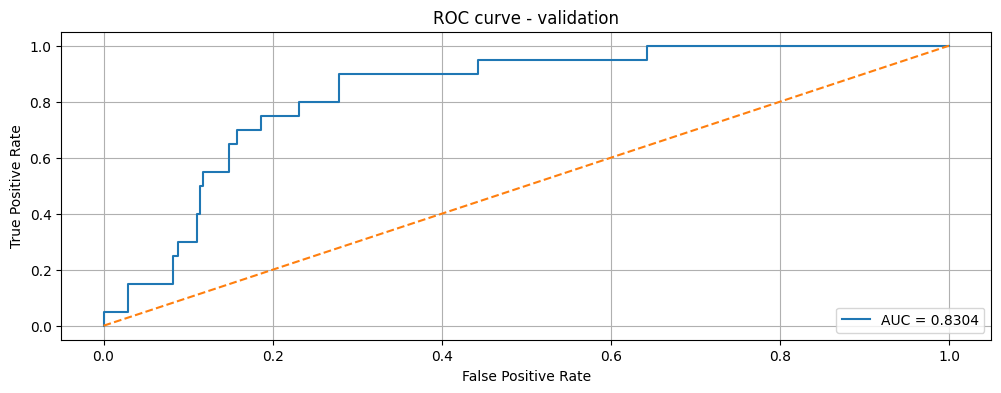


---------------------------------- Avaliação no test ---------------------------------

Accuracy: 0.6967032967032967

Classification report:
               precision    recall  f1-score   support

           0     0.9023    0.7195    0.8006       385
           1     0.2703    0.5714    0.3670        70

    accuracy                         0.6967       455
   macro avg     0.5863    0.6455    0.5838       455
weighted avg     0.8050    0.6967    0.7339       455

Confusion matrix:
 [[277 108]
 [ 30  40]]

ROC AUC: 0.6909090909090909


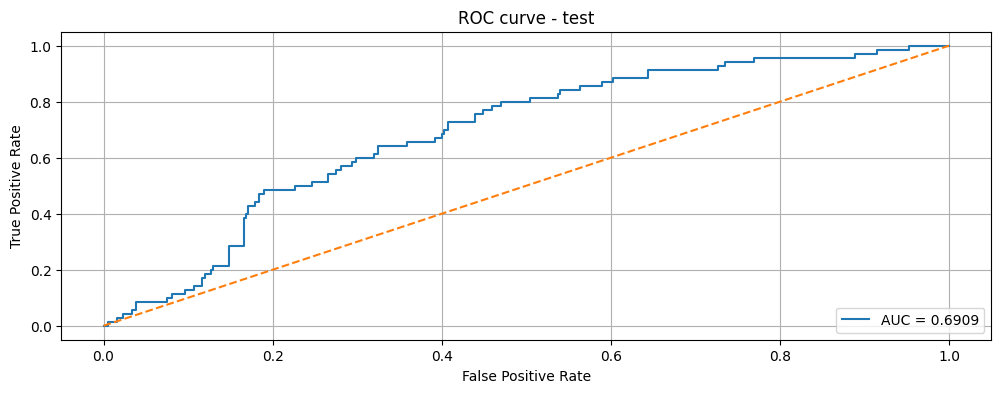

In [17]:
res_val = evaluate(best_model_res, X_val, y_val, set_name="validation")
res_test = evaluate(best_model_res, X_test, y_test, set_name="test")